In [1]:
from pyvis.network import Network
import matplotlib.pyplot as plt
import networkx as nx
import cv2
import numpy as np
img = cv2.imread('roma.jpg')
imgb = cv2.imread('roma.jpg', cv2.IMREAD_GRAYSCALE)
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
a = img.shape[0]
b = img.shape[1]
S = np.array([0])

In [2]:
lsc = cv2.ximgproc.createSuperpixelSLIC(hsv_img, 101, region_size=30, ruler=0.1)
lsc.iterate(100)
lsc.enforceLabelConnectivity(25)
Par = np.array([[0, 0, 0]]*lsc.getNumberOfSuperpixels(), dtype=float)
mask = lsc.getLabelContourMask()
label = lsc.getLabels()
print(len(Par))

475


In [3]:
for i in range(0, a):
    for j in range(0, b):
        n = label[i,j]
        Par[n-1][0] += 1
        Par[n-1][1] += hsv_img[i,j,2]
        Par[n-1][2] = (Par[n-1][1]/Par[n-1][0])
print(Par)

[[1.10900000e+03 7.41390000e+04 6.68521190e+01]
 [1.25700000e+03 7.54570000e+04 6.00294352e+01]
 [1.05000000e+03 4.75650000e+04 4.53000000e+01]
 ...
 [5.29000000e+02 1.13340000e+04 2.14253308e+01]
 [4.72000000e+02 1.84580000e+04 3.91059322e+01]
 [1.30300000e+03 6.08780000e+04 4.67214121e+01]]


In [4]:
S = np.array([[-1,-1,-1,-1,-1,-1,-1,-1,-1,-1]]*len(Par))
for i in range(0, a):
    for j in range(0, b-1):
        n1 = label[i,j]
        n2 = label[i, j+1]
        if n1 != n2:
            if n2 not in S[n1]:
                k = 0
                while k != -1:
                    if S[n1][k] == -1:
                        S[n1][k] = n2
                        k = -1
                    elif k == 9:
                        k = -1
                    else:
                        k += 1
            if n1 not in S[n2]:
                k = 0
                while k != -1:
                    if S[n2][k] == -1:
                        S[n2][k] = n1
                        k = -1
                    elif k == 9:
                        k = -1
                    else:
                        k += 1
for j in range(0, b):
    for i in range(0, a-1):
        n1 = label[i,j]
        n2 = label[i+1, j]
        if n1 != n2:
            if n2 not in S[n1]:
                k = 0
                while k != -1:
                    if S[n1][k] == -1:
                        S[n1][k] = n2
                        k = -1
                    elif k == 9:
                        k = -1
                    else:
                        k += 1
            if n1 not in S[n2]:
                k = 0
                while k != -1:
                    if S[n2][k] == -1:
                        S[n2][k] = n1
                        k = -1
                    elif k == 9:
                        k = -1
                    else:
                        k += 1
print(S)

[[  1  27  47 ...  -1  -1  -1]
 [  0   2  27 ...  -1  -1  -1]
 [  1   3  39 ...  -1  -1  -1]
 ...
 [443 446 471 ...  -1  -1  -1]
 [442 468 448 ...  -1  -1  -1]
 [444 448  -1 ...  -1  -1  -1]]


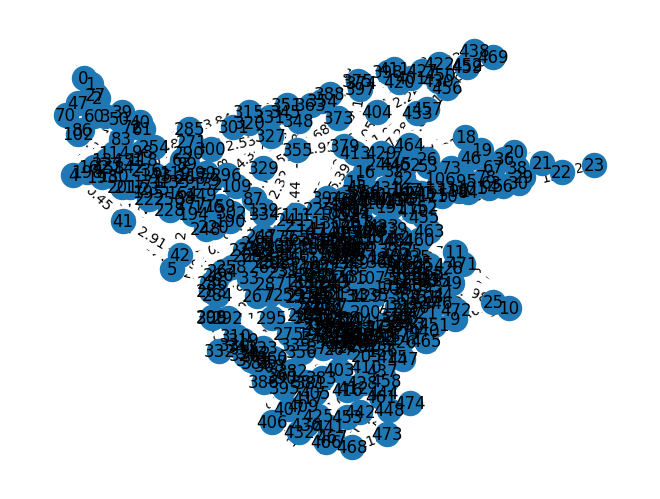

In [5]:
G = nx.Graph()  # создаём объект графа

# определяем список узлов (ID узлов)
nodes = np.array([0]*len(Par))
#print(len(nodes))

for i in range(0, len(nodes)):
    nodes[i] = i
G.add_nodes_from(nodes)
    
for i in range(0, len(S)):
    for j in range(0, 10):
        if S[i,j] != -1 and round((Par[i-1][2] - Par[S[i,j] - 1][2]), 2) >= 0.0:
            G.add_edge(i, S[i,j], weight=round((Par[i-1][2] - Par[S[i,j] - 1][2]), 2))

# рисуем граф и отображаем его
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.show()

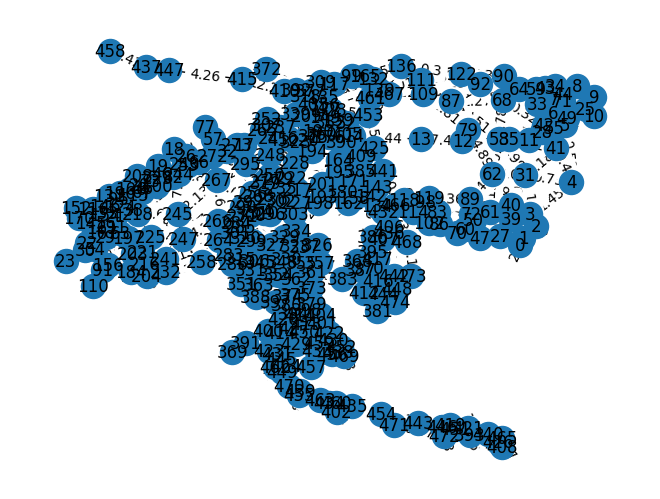

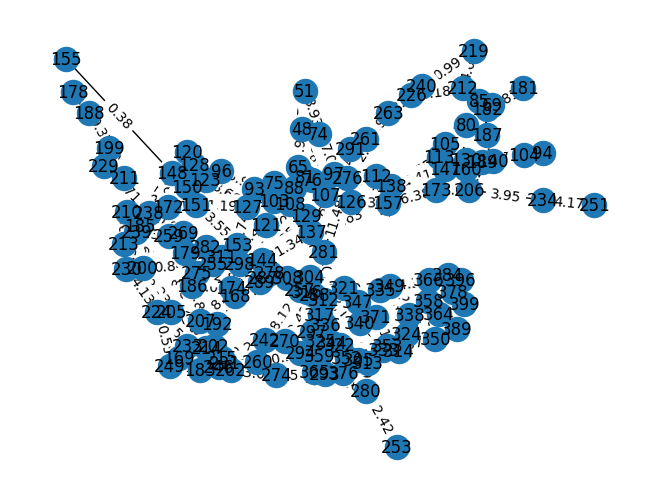

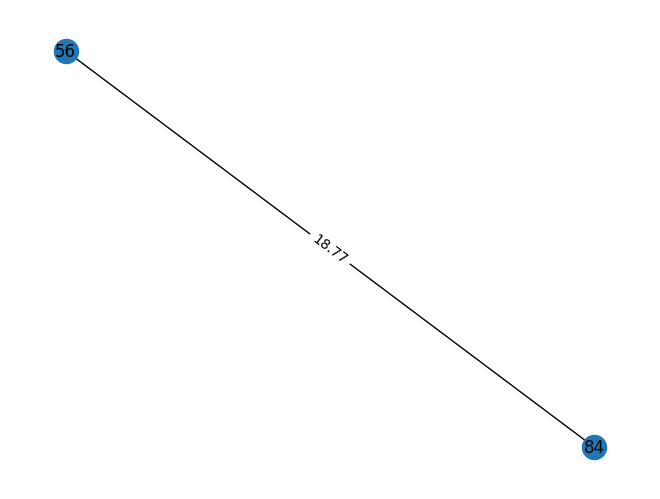

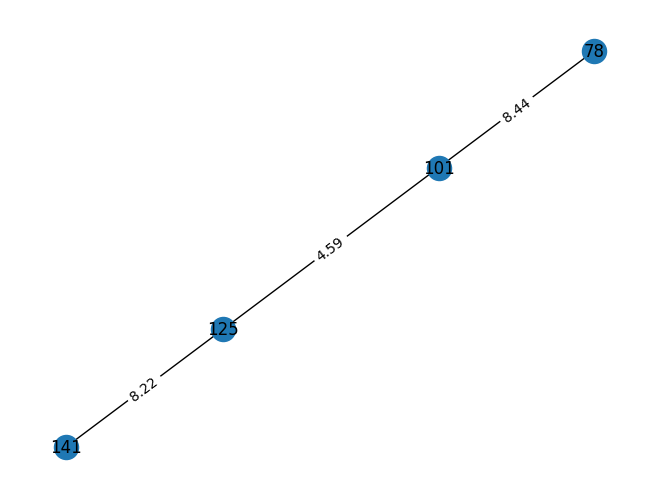

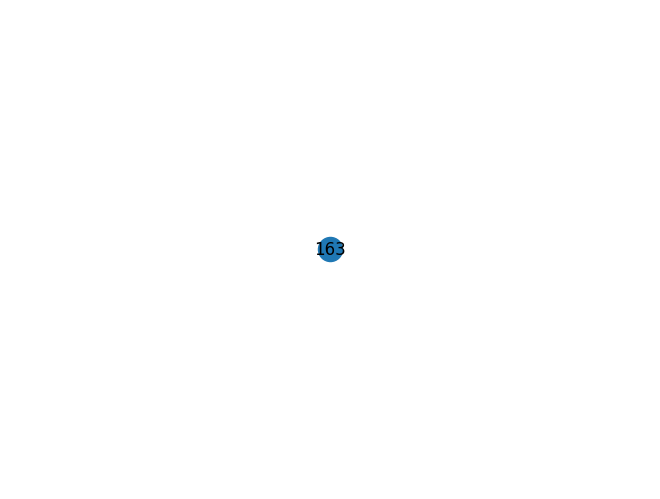

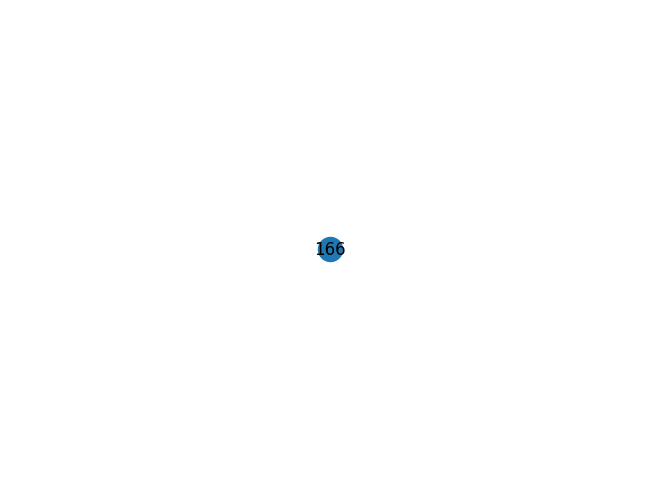

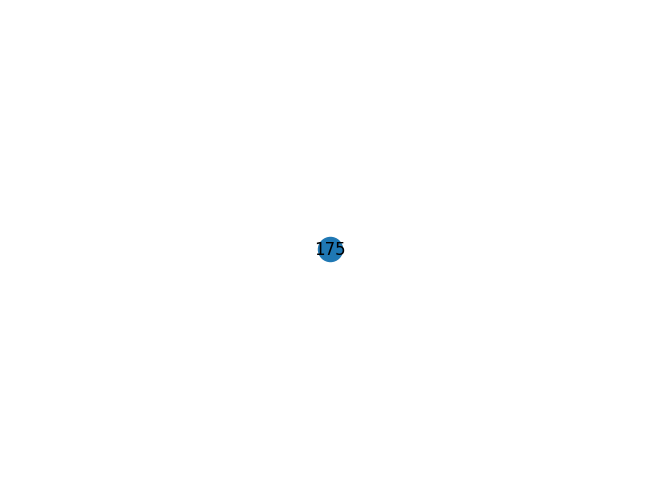

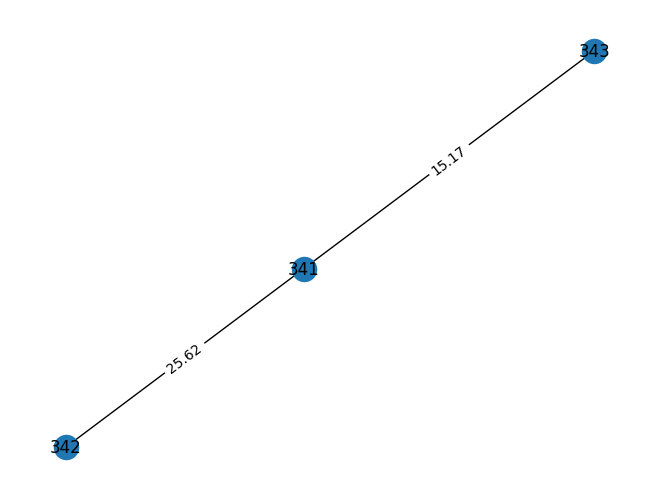

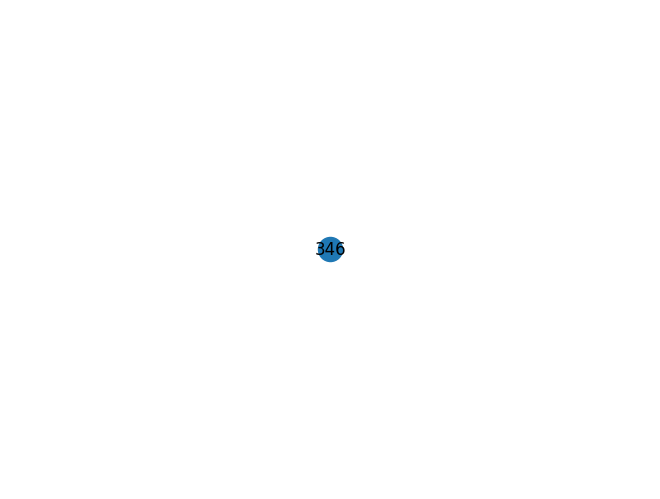

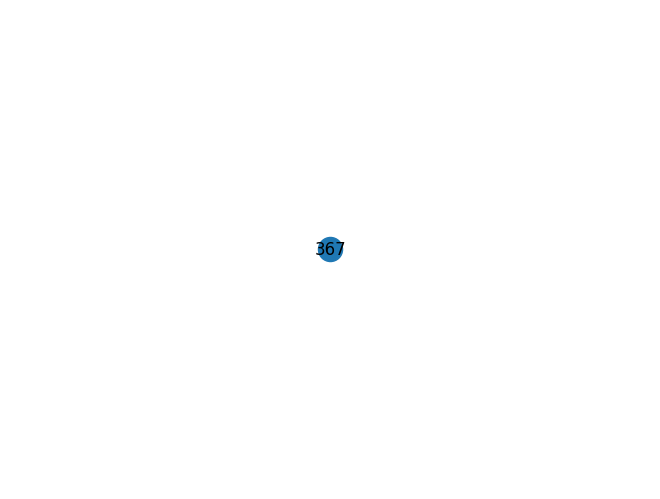

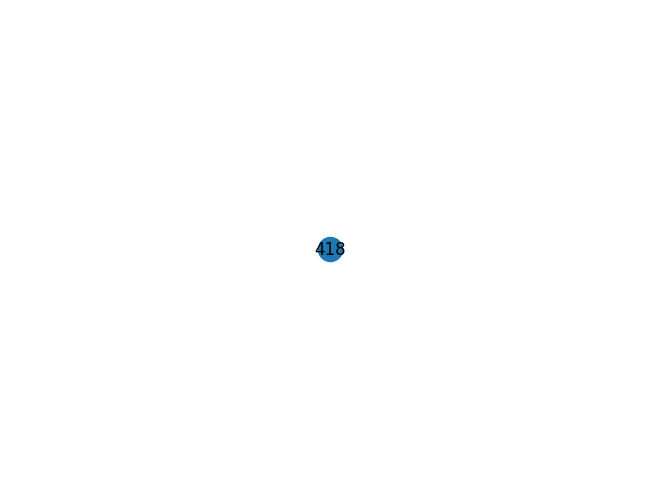

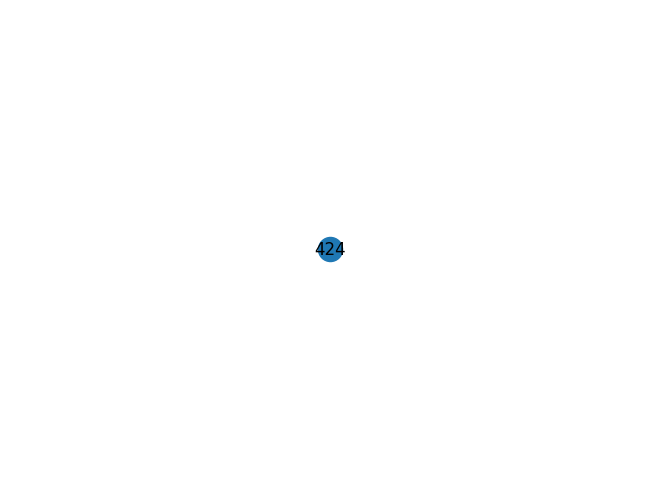

In [11]:
# Make a copy of the graph.
H = G.copy()
Ed = np.array([[0,0]])
nodes = list(H.nodes)
for i in nodes:
    h = list(H.adj[i].keys())
    #print(h)
    for j in range(0, len(h)):
        wt = H.edges[i, h[j]]["weight"]
        #print(wt)
        if wt > 30:
            z = h[j]
            Ed = np.append(Ed, [[i, z]], axis=0)
            H.remove_edge(i, z)
Ed = np.delete(Ed,(0), axis = 0)
subgraphs = [
        H.subgraph(c).copy() for c in nx.connected_components(H.to_undirected())
    ]
for subgraph in subgraphs:
    pos = nx.spring_layout(subgraph)
    nx.draw(subgraph, pos, with_labels=True)
    labels = nx.get_edge_attributes(subgraph, 'weight')
    nx.draw_networkx_edge_labels(subgraph, pos, edge_labels=labels)
    plt.show()

In [12]:
Se = np.array([[-1] * (len(subgraphs) - 1)] * len(subgraphs))
for i in range(0, len(subgraphs)):
    for j in range(0, len(subgraphs)):
        if i != j:
            #print(i,j)
            q = list(subgraphs[i].nodes)
            w = list(subgraphs[j].nodes)
            #print(q, w)
            for r in range(0, len(Ed)):
                if (Ed[r][0] in q and Ed[r][1] in w) or (Ed[r][0] in w and Ed[r][1] in q):
                    if j not in Se[i]:
                        k = 0
                        while k != -1:
                            if Se[i][k] == -1:
                                Se[i][k] = j
                                k = -1
                            elif k == 9:
                                k = -1
                            else:
                                k += 1
print(Se)
Pars = np.array([[0,0]]*len(subgraphs), dtype=float)
for i in range(0, len(subgraphs)):
    n = list(subgraphs[i].nodes)
    Pars[i][1] = len(n)
    for j in range(0, len(Par)):
        if j in n:
            Pars[i][0] += Par[j, 2]
    Pars[i][0] /= Pars[i][1] 
    print(Pars[i])

[[ 1  2  3  4  5  6  7  8  9 10 -1]
 [ 0  5  8  9 10 11 -1 -1 -1 -1 -1]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  4 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  3 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
 [ 0  1 -1 -1 -1 -1 -1 -1 -1 -1 -1]]
[ 91.96029796 313.        ]
[127.38992181 146.        ]
[119.79627716   2.        ]
[107.42287415   4.        ]
[53.04577114  1.        ]
[31.5626506  1.       ]
[77.17518248  1.        ]
[139.73818576   3.        ]
[238.83781279   1.        ]
[34.23730964  1.        ]
[46.15346535  1.        ]
[61.7325228  1.       ]


In [13]:
q = len(subgraphs)
w = 0
while q != w: #объединяем с ближайшими по мат ожиданию мелкие подграфы
    q = len(subgraphs)
    i = 0
    while i < len(subgraphs):
        n = list(subgraphs[i].nodes)
        m1 = Pars[i][0]
        if len(n) < 100:
            #print(i)
            t = Se[i][0]
            m2 = Pars[t][0]
            sr = np.array([abs(m2 - m1)], dtype=float)
            for j in range(1, len(Se[i])):
                if Se[i][j] != -1:
                    t = Se[i][j]
                    m2 = Pars[t][0]
                    sr = np.append(sr, abs(m1 - m2))
            z = 0
            for y in range(0, len(sr)):
                if sr[z] > sr[y]:
                    z = y
            t = Se[i][z]
            for p in range(0, len(Se)):
                for o in range(0, len(Se[0])):
                    if Se[p][o] == i:
                        if p != t:
                            Se[p][o] = t
                        else:
                            Se[p][o] = -1
                    if Se[p][o] > i:
                        Se[p][o] -= 1
            Se = np.delete(Se,(i), axis = 0)
            Pars[t][0] = (Pars[t][0] * Pars[t][1] + Pars[i][0]*Pars[i][1])/(Pars[t][1] + Pars[i][1])
            Pars[t][1] = (Pars[t][1] + Pars[i][1])
            Pars = np.delete(Pars, (i), axis = 0)
            subgraphs[t].add_nodes_from(n)
            sub = subgraphs[i]
            subgraphs.remove(sub)
            i = len(subgraphs) + 2
        i += 1
    w = len(subgraphs)
print(Pars)
Mid = 0
for i in range(0,len(Pars)-1):
    Mid += Pars[i][1]
#Mid /= len(Pars)
print(Mid)

[[ 91.99993528 328.        ]
 [128.14807072 147.        ]]
328.0


In [14]:
col = 0
A = 256/len(subgraphs)
for sub in subgraphs:
    check = list(sub.nodes)
    for i in range(0, a):
        for j in range(0, b):
            n = label[i,j]
            if n in check:
                imgb[i, j] = col
    col += A
cv2.imwrite('testh.jpg', imgb)

True

In [274]:
imgg = cv2.imread('roma_test.jpg', cv2.IMREAD_GRAYSCALE)
def T(I):
    S = 0
    N = len(I) * len(I[0])
    for i in range(len(I)):
        for j in range(len(I[0])):
            S += I[i,j]
    return 2 * S/N


def Pre(I):
    print(I[0,0], imgg[0,0])
    S = 0
    N = 0
    for i in range(len(I)):
        for j in range(len(I[0])):
            if I[i,j] != 0:
                N += 1
                if imgg[i,j] != 0:
                    S += 1
    print(S)
    print(N)
    return S/N

def Rec(I):
    print(I[0,0], imgg[0,0])
    S = 0
    N = 0
    for i in range(len(I)):
        for j in range(len(I[0])):
            if imgg[i,j] != 0:
                N += 1
                if I[i,j] != 0:
                    S += 1
    print(S)
    print(N)
    return S/N

pr = Pre(imgb)
rec = Rec(imgb)
print('Precision = ', pr)
print('Recall = ', rec)

B = 0.3
Fb = (1 + B**2) * rec * pr/(B**2 * pr + rec)
print('Fb = ', Fb)
print(T(imgb))


0 0
5880
110466
0 0
5880
246281
Precision =  0.053229047851827714
Recall =  0.0238751669840548
Fb =  0.04832343860939603
40.805190625


In [275]:
imgg = cv2.imread('roza_test.jpg', cv2.IMREAD_GRAYSCALE)
def T(I):
    S = 0
    N = len(I) * len(I[0])
    for i in range(len(I)):
        for j in range(len(I[0])):
            S += I[i,j]
    return 2 * S/N


def Pre(I):
    print(I[0,0], imgg[0,0])
    S = 0
    N = 0
    for i in range(len(I)):
        for j in range(len(I[0])):
            if I[i,j] == 0:
                N += 1
                if imgg[i,j] != 0:
                    S += 1
    print(S)
    print(N)
    return S/N

def Rec(I):
    print(I[0,0], imgg[0,0])
    S = 0
    N = 0
    for i in range(len(I)):
        for j in range(len(I[0])):
            if imgg[i,j] != 0:
                N += 1
                if I[i,j] == 0:
                    S += 1
    print(S)
    print(N)
    return S/N

pr = Pre(imgb)
rec = Rec(imgb)
print('Precision = ', pr)
print('Recall = ', rec)

B = 0.3
Fb = (1 + B**2) * rec * pr/(B**2 * pr + rec)
print('Fb = ', Fb)
print(T(imgb))

0 0
240401
529534
0 0
240401
246281
Precision =  0.45398595746448767
Recall =  0.9761248330159452
Fb =  0.474963616502026
40.805190625


In [36]:
while len(subgraphs) > 2:
    M = np.array([[0, 0]]*len(Pars), dtype=float)
    for i in range(len(Pars)):
        s = 256
        for j in range(len(Pars)):
            if i != j and abs(Pars[i][0] - Pars[j][0]) < s:
                s = abs(Pars[i][0] - Pars[j][0])
                M[i][0] = s
                M[i][1] = j
    print(M)
    t = 0
    z = 0
    s = 256
    for i in range(len(M)):
        if M[i][0] < s:
            s = M[i][0]
            t = i
            z = int(M[i][1])
    print(t, z)
    #print(Pars)
    Pars[t][0] = (Pars[t][0] * Pars[t][1] + Pars[z][0]*Pars[z][1])/(Pars[t][1] + Pars[z][1])
    Pars[t][1] = (Pars[t][1] + Pars[z][1])
    #print(Pars)
    Pars = np.delete(Pars, (z), axis = 0)
    #print(Pars)
    subgraphs[t].add_nodes_from(n)
    sub = subgraphs[z]
    subgraphs.remove(sub)
    #print(Se)
    print(Pars)
    Mid = 0
    for i in range(0,len(Pars)):
        Mid += Pars[i][1]
    #Mid /= len(Pars)
    print(Mid)
print(len(subgraphs))

[[ 2.52209874 13.        ]
 [26.40547494  3.        ]
 [ 6.61596914 11.        ]
 [26.40547494  1.        ]
 [ 8.99510545 16.        ]
 [ 5.47047108 10.        ]
 [ 5.06616589 14.        ]
 [10.80295512  5.        ]
 [ 5.95700098  6.        ]
 [ 8.58560718  8.        ]
 [ 5.47047108  5.        ]
 [ 3.75197063 13.        ]
 [ 0.63566843 14.        ]
 [ 2.52209874  0.        ]
 [ 0.63566843 12.        ]
 [ 8.77232313  9.        ]
 [ 0.96232943 12.        ]]
12 14
[[125.9937514  175.        ]
 [220.42002841   2.        ]
 [138.88378992 132.        ]
 [246.82550336   1.        ]
 [191.02958821   2.        ]
 [104.37634212 125.        ]
 [175.370319     1.        ]
 [ 93.57338701   2.        ]
 [169.41331803   1.        ]
 [160.82771084   1.        ]
 [109.8468132   23.        ]
 [132.26782077   1.        ]
 [180.54242963   6.        ]
 [128.51585014   1.        ]
 [152.05538771   1.        ]
 [182.03448276   1.        ]]
475.0
[[ 2.52209874 13.        ]
 [26.40547494  3.        ]
 [ 6.6159